## 신경망 사고 방식을 사용한 로지스틱 회귀

고양이를 인식하기 위해 로지스틱 회귀 분류기를 구축합니다. 이 과제는 신경망 사고방식(mindset)으로 이를 수행하는 방법을 안내하며 딥러닝에 대한 직관도 연마합니다.

### 1. 패키지

먼저 아래 셀을 실행하여 이 과제 중에 필요한 모든 패키지를 가져 오겠습니다.

* numpy는 Python을 사용한 과학 컴퓨팅의 기본 패키지입니다.
* [h5py](http://www.h5py.org)는 H5 파일에 저장된 데이터 세트와 상호 작용하는 공통 패키지입니다.
* matplotlib는 Python에서 그래프를 그리는 유명한 라이브러리입니다.
* 여기서 PIL과 [scipy](https://www.scipy.org/)는 마지막에 자신의 사진으로 모델을 테스트하는 데 사용됩니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.misc
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

### 2. 문제 세트 개요

**문제 설명** : 다음을 포함하는 데이터 세트("data.h5")가 제공됩니다.
* cat (y=1) 또는 non-cat (y=0)으로 레이블이 지정된 m_train 개 이미지의 훈련 세트
* cat 또는 non-cat로 표시된 m_test 개 이미지의 테스트 세트
* 각 이미지는 (num_px, num_px, 3) 모양이며, 3은 3 채널(RGB)용입니다. 따라서 각 이미지는 정사각형 (height=num_px) 및 (width=num_px)입니다.

사진들을 고양이 또는 고양이가 아닌 것으로 올바르게 분류 할 수 있는 간단한 이미지 인식 알고리즘을 구축합니다.

데이터 세트에 대해 좀 더 알아 봅시다. 다음 코드를 실행하여 데이터를 로드합니다.

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

이미지 데이터 세트 (train 및 test) 끝에 "_orig"를 추가했습니다. 전처리 후에 train_set_x 및 test_set_x로 표시합니다 (train_set_y 및 test_set_y 레이블에는 전처리가 필요하지 않음).

train_set_x_orig 및 test_set_x_orig의 각 줄은 이미지를 나타내는 배열입니다. 다음 코드를 실행하여 예제를 시각화 할 수 있습니다. 다른 이미지를 보려면 index 값을 변경하고 다시 실행하십시오.

y = [1], it's a 'cat' picture.


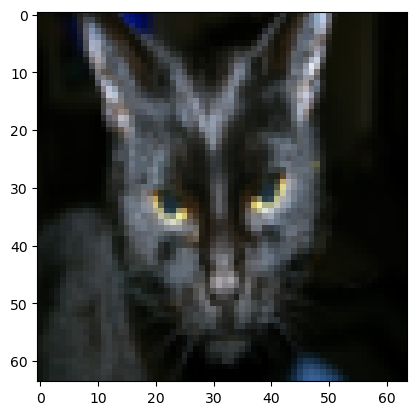

In [8]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

딥 러닝의 많은 소프트웨어 버그는 적합하지 않은 행렬/벡터 차원에서 비롯됩니다. 행렬/벡터 차원을 똑바로 유지할 수 있다면 많은 버그를 제거하는 데 큰 도움이 될 것입니다.

**(1) 연습 문제** : 다음에 대한 값 찾기 :

* m_train (훈련 예제 수)
* m_test (테스트 예제 수)
* num_px (= 훈련 이미지의 높이 = 훈련 이미지의 너비)
* `train_set_x_orig`는 (m_train, num_px, num_px, 3) 모양의 numpy 배열입니다 . 예를 들어 `train_set_x_orig.shape[0]` 으로 `m_train` 에 액세스 할 수 있습니다.

In [25]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = 
m_test = 
num_px =
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>m_train</td>
    <td> 209 </td> 
  </tr>
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
</table>

편의를 위해, 이제 (num_px, num_px, 3)의 이미지 모양을 (num_px $*$ num_px $*$ 3, 1)모양의 numpy 배열로 변경해야 합니다. 그 후 학습(및 테스트) 데이터 세트는 각 열이 편편해진 이미지를 나타내는 numpy-array입니다. m_train(각각 m_test) 열이 있어야 합니다.

**(2) 연습 문제** : 크기 (num_px, num_px, 3)의 이미지가 (num_px $*$ num_px $*$ 3, 1) 모양의 단일 벡터로 병합되도록 훈련 및 테스트 데이터 세트의 모양을 변경합니다.

[Hint] 모양 (a, b, c, d)의 행렬 X를 (b $*$ c $*$ d, a)모양의 행렬 X_flatten 으로 평면화하려는 경우 트릭은 다음을 사용하는 것입니다.
```python
    X_flatten = X.reshape(X.shape[0], -1).T  # X.T는 X의 전치입니다.
```

In [26]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten =
test_set_x_flatten = 
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:55%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>sanity check after reshaping</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

컬러 이미지를 표현하려면 각 픽셀에 대해 RGB (빨강, 녹색 및 파랑 채널)를 지정해야하므로 픽셀 값은 실제로 0에서 255 사이의 세 숫자로 구성된 벡터입니다.

머신 러닝의 일반적인 전처리 단계 중 하나는 데이터 세트를 중앙에 배치하고 정규화하는 것입니다. 즉, 각 예에서 전체 numpy 배열의 평균을 뺀 다음, 각 예를 전체 numpy 배열의 표준 편차로 나눕니다. 그러나 사진 데이터 세트의 경우 더 간단하고 편리하며, 데이터 세트의 모든 행을 255 (픽셀 채널의 최대 값)로 나누는 것과 거의 비슷합니다.

이런 방법으로 데이터 세트를 정규화합시다.

In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

새 데이터 세트를 사전 처리하는 일반적인 단계는 다음과 같습니다.

* 문제의 크기와 모양 파악 (m_train, m_test, num_px, ...)
* 각 예제가 이제 크기 (num_px * num_px * 3, 1)의 벡터가 되도록 데이터 세트의 형태를 변경합니다.
* 데이터 "표준화"

### 3. 학습 알고리즘의 일반 아키텍처
고양이 이미지와 고양이가 아닌 이미지를 구별하는 간단한 알고리즘을 디자인 할 때입니다.

신경망정 사고 방식을 사용하여 로지스틱 회귀를 구축합니다. 다음 그림은 로지스틱 회귀가 실제로 매우 단순한 신경망인 이유를 설명합니다!

<img src="./images/LogReg.png" style="width:650px;height:400px;">

#### 알고리즘의 수학적 표현 :

예를 들어, 한 예제 $x^{(i)}$에 대하여 :

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$

$$\hat{y}^{(i)} = a^{(i)} = \text{sigmoid}(z^{(i)})\tag{2}$$

$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

그런 다음 모든 학습 예제들에 대한 손실을 합산하여 비용을 계산합니다.:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**주요 단계** :이 연습에서는 다음 단계를 수행합니다.

- 모델의 매개 변수 초기화
- 비용을 최소화하여 모델에 대한 매개 변수 학습
- 학습된 매개 변수를 사용하여 예측하기(테스트 세트에서)
- 결과 분석 및 결론

## 4. 알고리즘 부분 구축

신경망을 구축하는 주요 단계는 다음과 같습니다.

1. 모델 구조 정의 (예 : 입력 특징의 수)
2. 모델의 매개변수 초기화
3. 반복:
    - 현재 손실 계산 (순방향 전파)
    - 현재 기울기 계산 (역방향 전파)
    - 매개변수 업데이트 (경사하강법)

우리는 종종 1~3을 별도로 구축하고, model( )이라고 부르는 하나의 함수로 통합합니다.

### 4.1 도움 함수들

**(3) 연습 문제** : "Python 기초"의 코드를 사용하여  `sigmoid()`를 구현합니다. 위의 그림에서 보았듯이 예측을 하기위해서 $\text{sigmoid}(w^T x + b) = \frac{1}{1+e^{-(w^T x + b)}} $를 계산해야 하며, 이 때 np.exp( )를 사용하십시오.

In [28]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)abs
    s = 
    ### END CODE HERE ###
    
    return s

print("sigmoid([0,2]) = ", sigmoid(np.array([0,2])))

sigmoid([0,2]) =  [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>sigmoid([0, 2])</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2. 매개 변수 초기화
**(4) 연습 문제** : 아래 셀에서 매개 변수 초기화를 구현하십시오. w를 0으로 채워진 벡터로 초기화 해야합니다. 사용할 numpy 함수를 모르는 경우 Numpy 라이브러리 문서에서 `np.zeros()`를 참고하십시오.

In [29]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 2 line of code)
    w = 
    b = 
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 

<table style="width:25%">
    <tr>
        <td> w </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  b   </td>
        <td> 0 </td>
    </tr>
</table>
이미지 입력의 경우 w는 (num_px  $\times$ num_px  $\times$ 3, 1) 모양이 됩니다. 

### 4.3. 순방향 및 역방향 전파

이제 매개변수가 초기화되었으므로, 매개변수 학습을 위해 "순방향" 및 "역방향"전파 단계를 수행할 수 있습니다.

**(5) 연습 문제** : 비용 함수와 그 기울기를 계산하는 `propagate()` 함수를 구현하세요.

**힌트** :

순방향 전파 :

- 당신은 X를 얻습니다
- $ A= \sigma (w^T X + b) = (a^{(1)}, a^{(2)}, \cdots, a^{(m-1)}, a^{( m)}) $ 를 계산합니다.
- 비용 함수를 계산합니다. $ J =-\frac {1}{m} \sum_{i = 1}^{m} y^{(i)}\log(a^{(i)}) + (1-y^{(i)}) \log (1-a^{(i)}) $

사용할 두 가지 공식은 다음과 같습니다.

$$ \frac{\partial J} {\partial w} = \frac {1}{m} X (A-Y)^T \tag {7} $$

$$ \frac{\partial J} {\partial b} = \frac {1}{m} \sum_{i = 1}^ m (a^{(i)}-y^{(i)}) \tag {8} $$

In [30]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A =                                                            # compute activation
    cost =                                                         # compute cost
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw =  
    db =  
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
* $w^T X$ 연산은 numpy array 들에 대하여 `np.dot(w.T, X)`로 구현된다.
* $ y^{(i)}\log(a^{(i)}) $  연산은 numpy array 들에 대하여 `Y * np.log(A)` 로 구현된다.
* $ X (A-Y)^T$ 연산은 numpy array 들에 대하여 `np.dot(X, (A-Y).T)` 로 구현된다.
</details>

**Expected Output**:

<table style="width:60%">
    <tr>
      <td>   dw   </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>   db   </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>   cost   </td>
        <td> 5.801545319394553 </td>
    </tr>
</table>

### 4.4. 최적화(Optimization)

- 매개 변수를 초기화 했습니다.
- 비용 함수와 그 기울기를 계산할 수도 있습니다.
- 이제, 경사하강 법을 사용하여 매개 변수를 업데이트하려고 합니다.

**(6) 연습 문제** : 최적화 함수를 적어보세요. 목표는 비용 함수 $ J $를 최소화하여 $ w $ 및 $ b $를 학습하는 것입니다. 매개 변수 $ \theta $의 경우 업데이트 규칙은 $ \theta = \theta-\alpha \text{ } d \theta $입니다. 여기서 $ \alpha $는 학습률입니다.

In [31]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost =  
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w =  
        b =  
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
* grads, cost 에 대한 계산은 앞에서 구현한 `propagate()` 함수를 사용한다.
</details>

**Expected Output**: 

<table style="width:60%">
    <tr>
       <td> w </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> b</td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> dw </td>
       <td> [[ 0.67752042] [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> db</td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**(7) 연습 문제** : 이전 기능은 학습 된 w와 b를 출력합니다. w와 b를 사용하여 데이터 세트 X의 레이블을 예측할 수 있습니다. predict( ) 함수를 구현합니다. 예측을 계산하는 데는 두 단계가 있습니다.

1. $\hat{Y} = A = \sigma (w^T X + b)$ 계산
2. a의 항목을 0 (활성화 <= 0.5) 또는 1 (활성화> 0.5)로 변환하고, 예측을 벡터 Y_prediction에 저장합니다. 원한다면 for 루프에서 if/else 문을 사용할 수 있습니다 (이를 벡터화하는 방법도 있지만).


In [32]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A =  
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] <= 0.5:
            Y_prediction[0, i] =
        else:
            Y_prediction[0, i] = 
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
*  $A = \sigma (w^T X + b)$에 대한 계산은 `sigmoid()` 함수와 $w^T X $ 에 대한 계산의  구현 `np.dot(w.T, X)`을 조합하여 사용한다.
</details>

**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>predictions </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>
</table>

* 초기화 (w, b)
* 반복적으로 손실을 최적화하여 매개 변수 (w, b)를 학습합니다.
    - 비용과 기울기 계산
    - 경사 하강 법을 사용하여 매개 변수 업데이트
* 학습된 (w, b)를 사용하여 주어진 예제 세트에 대한 레이블을 예측합니다.

### 5. 모든 기능을 모델에 병합

이제 모든 빌딩 블록 (이전 부분에서 구현된 기능)을 올바른 순서로 모아 전체 모델이 어떻게 구성되는지 볼 수 있습니다.

**(8) 연습 문제**: 모델 기능을 구현합니다. 다음 표기법을 사용하십시오.

- 테스트 세트에 대한 예측을 위한 Y_prediction_test
- 기차 세트에 대한 예측을 위한 Y_prediction_train
- optimize( )의 출력에 대한 w, 비용, 그래디언트

In [33]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b =  
    
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = 
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test =  
    Y_prediction_train =  

    ### END CODE HERE ###
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
*  $w$에 대한 초기화는  `np.zeros()` 함수를 사용하여  '0' 으로 채워진 `(X_train.shape[0], 1)` 크기의 배열을 생성하고, $b$ 에 대한 초기화는 스칼라변수에 `0`를 할당하여 수행한다.
</details>

**Expected Output**: 

<table style="width:50%"> 
    <tr>
        <td> Cost after iteration 0  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td>Train Accuracy  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>Test Accuracy </td> 
        <td> 70.0 % </td>
    </tr>
</table> 

**설명** : 훈련 정확도는 100%에 가깝습니다. 이것은 좋은 온전성 검사입니다. 모델이 작동하고 있으며 훈련 데이터에 맞을 만큼 충분한 용량이 있습니다. 테스트 정확도는 70%입니다. 우리가 사용한 작은 데이터 세트와 로지스틱 회귀가 선형 분류기라는 점을 감안할 때이 간단한 모델에는 실제로 나쁘지 않습니다. 하지만 걱정하지 마세요. 다음 주에 더 나은 분류기를 만들 수 있습니다!

또한 모델이 훈련 데이터를 분명히 과적합하고 있음을 알 수 있습니다. 이 전문화 후반부에서 정규화를 사용하여 과적합을 줄이는 방법을 배웁니다. 아래 코드를 사용하고 인덱스 변수를 변경하면 테스트 세트의 그림에 대한 예측을 볼 수 있습니다.

y = [1], you predicted that it is a "cat" picture.


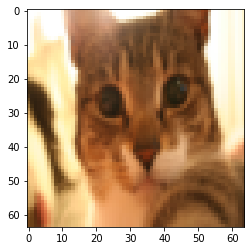

In [34]:
# Example of a picture that was wrongly classified.
index = 11
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[:,index]) + ", you predicted that it is a \"" + classes[np.squeeze(test_set_y[:,index])].decode("utf-8") +  "\" picture.")

y = [1], you predicted that it is a "cat" picture.


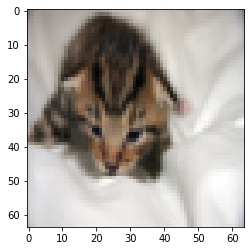

In [35]:
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[:,index]) + ", you predicted that it is a \"" + classes[np.squeeze(test_set_y[:,index])].decode("utf-8") +  "\" picture.")

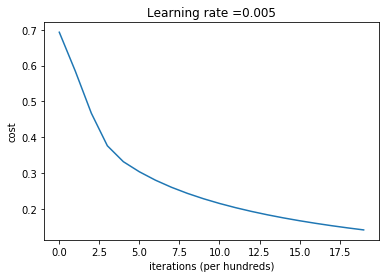

In [36]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**해석** : 비용이 감소하는 것을 볼 수 있습니다. 매개 변수가 학습되고 있음을 보여줍니다. 그러나 학습 세트에서 모델을 더 많이 학습 할 수 있음을 알 수 있습니다. 위의 셀에서 반복 횟수를 늘리고 셀을 다시 실행하십시오. 훈련 세트 정확도는 올라가지 만 테스트 세트 정확도는 내려가는 것을 볼 수 있습니다. 이를 과적합이라고 합니다.

## 6-추가 분석 (선택 사항/비평가 연습)

첫 번째 이미지 분류 모델을 구축한 것을 축하합니다. 더 자세히 분석하고 학습률 $ \alpha $에 대해 가능한 선택 사항을 살펴 보겠습니다.

#### 학습률 선택 ####

**조언**:
Gradient Descent가 작동하려면 학습률을 현명하게 선택해야 합니다. 학습률 $ \alpha $는 매개변수 업데이트 속도를 결정합니다. 학습률이 너무 크면 최적 값을 "지나칠" 수 있습니다. 마찬가지로 너무 작으면 최상의 값으로 수렴하기 위해 너무 많은 반복이 필요합니다. 그렇기 때문에 잘 조정된 학습률을 사용하는 것이 중요합니다.

우리 모델의 학습 곡선을 여러 학습률 선택과 비교해 봅시다. 아래 셀을 실행하십시오. 약 1 분 정도 소요됩니다. 또한 포함 할 `learning_rates` 변수를 초기화 한 세 가지 값과 다른 값을 시도하고 어떤 일이 발생하는지 확인하십시오.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



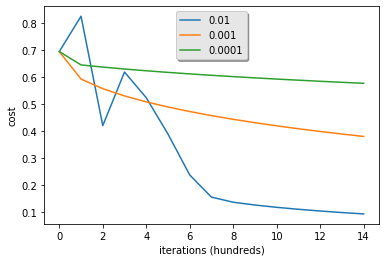

In [37]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**해석**:
- 학습률이 다르면 비용이 다르므로 예측 결과가 다릅니다.
- 학습률이 너무 크면 (0.01) 비용이 오르 내릴 수 있습니다. 심지어 발산할 수도 있습니다 (이 예에서는 0.01을 사용하더라도 결국 비용 대비 좋은 값이 됩니다).
- 더 낮은 비용이 더 나은 모델을 의미하지는 않습니다. 과적합이 있는지 확인해야 합니다. 훈련 정확도가 테스트 정확도보다 훨씬 높을 때 발생합니다.
- 딥 러닝에서는 일반적으로 다음을 권장합니다.
     - 비용 함수를 최소화하는 학습률을 선택하세요.
     - 모델이 과적합되면 다른 기술을 사용하여 과적합을 줄이십시오. (이에 대해서는 이후 비디오에서 설명하겠습니다.)

## 7. 자신의 이미지로 테스트하기 (선택 사항 / 비평가 연습) ##

이 과제를 마치 신 것을 축하드립니다. 자신의 이미지를 사용하고 모델의 출력을 볼 수 있습니다. 하기 위해서:
     1. 이 노트북의 상단 표시 줄에서 "File"을 클릭 한 다음 "Open"를 클릭하여 Coursera Hub로 이동합니다.
     2. 이 Jupyter Notebook의 디렉토리에 있는 "images"폴더에 이미지를 추가합니다.
     3. 다음 코드에서 이미지 이름 변경
     4. 코드를 실행하고 알고리즘이 올바른지 확인하십시오 (1 = 고양이, 0 = 고양이가 아님)!

(681, 1024, 3) 64
y = 1.0, your algorithm predicts a "cat" picture.


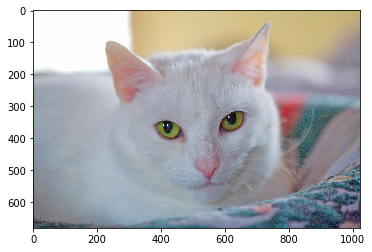

In [63]:
from skimage.transform import resize
from imageio import imread

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image2.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(imread(fname))
image = image/255.
print(image.shape, num_px)

my_image = resize(image,(num_px,num_px))
my_image = my_image.reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**이 과제에서 기억해야 할 사항 :** 
1. 데이터 세트를 사전 처리하는 것이 중요합니다. 
2. 각 함수를 개별적으로 구현했습니다 : initialize( ), propagate( ), optimize( ). 그런 다음 model( )을 빌드했습니다. 
3. 학습률("초매개변수"의 예)을 조정하면 알고리즘에 큰 차이를 만들 수 있습니다. 이 과정의 뒷부분에서 이에 대한 더 많은 예제를 볼 수 있습니다!


마지막으로, 원하신다면 이 노트북에서 다양한 작업을 시도해보십시오. 시도하기 전에 반드시 제출하십시오. 제출 한 후에는 다음과 같은 작업을 수행 할 수 있습니다.
- 학습률 및 반복 횟수로 재생
- 다른 초기화 방법을 시도하고 결과를 비교합니다.
- 다른 전처리를 테스트합니다 (데이터를 중앙에 배치하거나 각 행을 표준 편차로 나누기).

Bibliography:

- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c